In [1]:
!pip install adversarial-robustness-toolbox

     |████████████████████████████████| 655kB 4.6MB/s 
     |████████████████████████████████| 7.1MB 12.1MB/s 
     |████████████████████████████████| 235kB 33.7MB/s 
     |████████████████████████████████| 20.8MB 1.3MB/s 
     |████████████████████████████████| 747kB 42.6MB/s 
  Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-learn-0.22.2.post1:
      Successfully uninstalled scikit-learn-0.22.2.post1


In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import activationsf # Where the Kaf Layer is implemented
import fbfadvtrain # Where Fast Adversarial Training is implemented

from activationsf import Kaf, plot_kafs_epoch_wise

from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, Add, Input, ZeroPadding2D, GlobalAveragePooling2D, Dense, Flatten, MaxPooling2D, Dropout
from tensorflow.keras.regularizers import l2 
from tensorflow.keras import Model
from tensorflow import math 

tf.keras.mixed_precision.experimental.set_policy('mixed_float16')
regularizer = l2(0.0005)

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: Tesla T4, compute capability 7.5


In [4]:
# 2.3.0 at the time of writing
print(tf.__version__)

2.3.0


In [2]:
# Load CIFAR10
from tensorflow.keras.datasets import cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [3]:
def cifar_res_block(x, s, filters, activation, kaf=False): 
  """ 
    Residual Block
  """

  x_skip = x # this will be used for addition with the residual block

  # First convolution, feature space halves when s=2 
  x = Conv2D(filters, kernel_size=(3, 3), strides=(s, s), padding='same', kernel_regularizer = regularizer)(x)
  x = BatchNormalization()(x)
  if kaf is not False:
    x = Kaf(20, True) (x)
  else:
    x = Activation(activation)(x)

  # Second convolution, no dimensionality reduction
  x = Conv2D(filters, kernel_size=(3, 3), strides=(1, 1), padding='same', kernel_regularizer = regularizer)(x)

  # Project to a lower feature space the residual too if there was a dim reduction during 1st conv
  if s > 1:
    x_skip = Conv2D(filters, kernel_size=(3, 3), strides=(s, s), padding='same', kernel_regularizer = regularizer)(x_skip)
  
  # Add the input
  x = Add()([x, x_skip])
  x = BatchNormalization()(x)
  if kaf is not False:
    x = Kaf(20, True)(x)
  else:
    x = Activation(activation)(x)

  return x

In [4]:
# Use tf.data to improve performances
train = tf.data.Dataset.from_tensor_slices((x_train, y_train))
test = tf.data.Dataset.from_tensor_slices((x_test, y_test))

In [5]:
# Data augmentation 
def normalize(img, label):
  img = tf.cast(img, tf.float32)
  return img/255.0, label
def augment(img, label):
  img, _ = normalize(img, label)
  img = tf.image.resize_with_crop_or_pad(img, 40, 40) # Pad evenly w/ four 0s pixels
  img = tf.image.random_flip_left_right(img) # Random horizontal flip
  img = tf.image.random_crop(img, [32, 32, 3]) # Randomly crop back to cifar dimensionality
  return img, label

In [6]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train = (
    train
    .shuffle(1000)
    .map(augment, num_parallel_calls=AUTOTUNE)
    .batch(128)
    .prefetch(AUTOTUNE)
)
test = (
    test
    .shuffle(1000)
    .map(normalize, num_parallel_calls=AUTOTUNE)
    .batch(128)
    .prefetch(AUTOTUNE)
)  

## Adversarial Training

In [7]:
def resnet20(act = None, is_kaf = False):

  input = Input(shape=(32,32,3)) # padded cifar10 images size

  # Preparation Step
  x = Conv2D(16, kernel_size=(3, 3), padding='same', kernel_regularizer = regularizer)(input)
  x = BatchNormalization()(x)
  if is_kaf is not False:
    x = Kaf(20, True) (x)
  else:
    x = Activation(act)(x)

  # 1st stage: filter size 16, keep feature map size 
  x = cifar_res_block(x, s=1, filters=16, activation = act, kaf = is_kaf)
  x = cifar_res_block(x, s=1, filters=16, activation = act, kaf = is_kaf)
  x = cifar_res_block(x, s=1, filters=16, activation = act, kaf = is_kaf)

  # 2nd stage: double filter size, half feature map size
  x = cifar_res_block(x, s=2, filters=32, activation = act, kaf = is_kaf)
  x = cifar_res_block(x, s=1, filters=32, activation = act, kaf = is_kaf)
  x = cifar_res_block(x, s=1, filters=32, activation = act, kaf = is_kaf)

  # 3rd stage: double filter size, half feature map size
  x = cifar_res_block(x, s=2, filters=64, activation = act, kaf = is_kaf)
  x = cifar_res_block(x, s=1, filters=64, activation = act, kaf = is_kaf)
  x = cifar_res_block(x, s=1, filters=64, activation = act, kaf = is_kaf)

  x = GlobalAveragePooling2D()(x)

  x = Dense(10, activation='softmax', kernel_initializer='he_normal', dtype=tf.float32, kernel_regularizer = regularizer)(x) 

  model = fbfadvtrain.FastBetterFreeTrainedModel(inputs=input, outputs=x, name='resnet')

  return model

In [ ]:
# Relu case
resnet_20_original = resnet20(act=tf.keras.activations.relu)

In [ ]:
resnet_20_original.compile(
              optimizer = tf.keras.optimizers.SGD(learning_rate=0.1, momentum=0.9),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy']
              )

In [ ]:
# Find the min max lr meaningful bounds to cycle through
# Ref: https://www.machinecurve.com/index.php/2020/02/25/training-your-neural-network-with-cyclical-learning-rates/
# Note need to make lRFinder/keras_callback.py tf compatible
!git clone https://github.com/WittmannF/LRFinder.git

Cloning into 'LRFinder'...
remote: Enumerating objects: 71, done.
remote: Counting objects: 100% (71/71), done.
remote: Compressing objects: 100% (64/64), done.
remote: Total 71 (delta 24), reused 22 (delta 5), pack-reused 0
Unpacking objects: 100% (71/71), done.


Epoch 1/15
391/391 [==============================] - 61s 156ms/step - loss: 3.1873 - accuracy: 0.0151 - val_loss: 2.7440 - val_accuracy: 0.1000
Epoch 2/15
391/391 [==============================] - 60s 154ms/step - loss: 3.1868 - accuracy: 0.0152 - val_loss: 2.7142 - val_accuracy: 0.1000
Epoch 3/15
391/391 [==============================] - 60s 154ms/step - loss: 3.1878 - accuracy: 0.0150 - val_loss: 2.6948 - val_accuracy: 0.0992
Epoch 4/15
391/391 [==============================] - 60s 153ms/step - loss: 3.1864 - accuracy: 0.0150 - val_loss: 2.6827 - val_accuracy: 0.0899
Epoch 5/15
391/391 [==============================] - 60s 154ms/step - loss: 3.1815 - accuracy: 0.0147 - val_loss: 2.6750 - val_accuracy: 0.0762
Epoch 6/15
391/391 [==============================] - 60s 153ms/step - loss: 3.1785 - accuracy: 0.0140 - val_loss: 2.7440 - val_accuracy: 0.1000
Epoch 7/15
391/391 [==============================] - 61s 156ms/step - loss: 3.1686 - accuracy: 0.0135 - val_loss: 2.7134 - val_ac

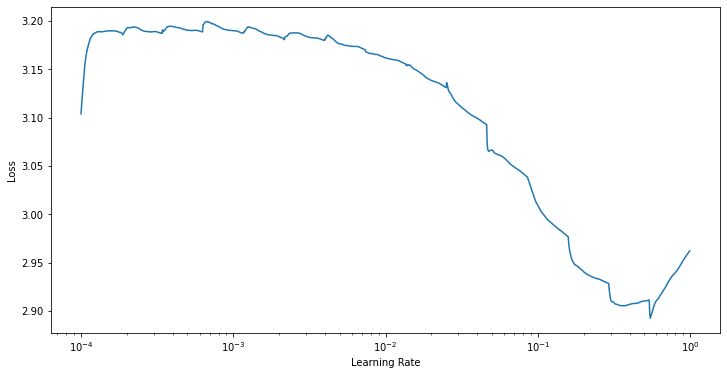

In [ ]:
from LRFinder.keras_callback import LRFinder
lr_finder = LRFinder(min_lr=1e-4, max_lr=1) # implemented as a callback

# Perform lr range test on 10 epochs
resnet_20_original.fit(x=train, epochs = 15, batch_size=128, validation_data=test, callbacks=[lr_finder])

In [ ]:
# Set up cyclic learning (linear)
# ref: same as above
!git clone https://github.com/bckenstler/CLR.git
from CLR.clr_callback import CyclicLR

# Set CLR options
step_size = int(3 * (50000/128))
base_lr = 1e-2
max_lr = 4e-1
mode='triangular'

# Define the callback
clr = CyclicLR(base_lr=base_lr, max_lr=max_lr, step_size=step_size, mode=mode)

Cloning into 'CLR'...
remote: Enumerating objects: 8, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 252 (delta 1), reused 4 (delta 0), pack-reused 244
Receiving objects: 100% (252/252), 2.06 MiB | 29.69 MiB/s, done.
Resolving deltas: 100% (87/87), done.


In [ ]:
history = resnet_20_original.fit(x = train, epochs=150, validation_data=test, callbacks=[clr])

Epoch 1/150
391/391 [==============================] - 52s 133ms/step - loss: 2.6794 - accuracy: 0.0904 - val_loss: 2.6166 - val_accuracy: 0.1240
Epoch 2/150
391/391 [==============================] - 52s 132ms/step - loss: 2.5114 - accuracy: 0.1364 - val_loss: 2.7368 - val_accuracy: 0.1244
Epoch 3/150
391/391 [==============================] - 52s 133ms/step - loss: 2.2231 - accuracy: 0.2190 - val_loss: 2.0407 - val_accuracy: 0.3383
Epoch 4/150
391/391 [==============================] - 51s 132ms/step - loss: 2.0494 - accuracy: 0.2634 - val_loss: 1.8352 - val_accuracy: 0.3965
Epoch 5/150
391/391 [==============================] - 52s 133ms/step - loss: 1.9274 - accuracy: 0.2911 - val_loss: 1.8157 - val_accuracy: 0.4082
Epoch 6/150
391/391 [==============================] - 52s 133ms/step - loss: 1.8451 - accuracy: 0.3119 - val_loss: 1.6297 - val_accuracy: 0.4830
Epoch 7/150
391/391 [==============================] - 52s 133ms/step - loss: 1.8176 - accuracy: 0.3210 - val_loss: 1.6518 -

In [ ]:
# Buffer limit reached for the output on the previous cell, thus evaluate
resnet_20_original.evaluate(x=test, batch_size=128)

79/79 [==============================] - 2s 25ms/step - loss: 0.8948 - accuracy: 0.7658


[0.8948258757591248, 0.7657999992370605]

In [ ]:
resnet_20_original.evaluate(x=train, batch_size=128)

391/391 [==============================] - 9s 24ms/step - loss: 0.8812 - accuracy: 0.7871


[0.8811555504798889, 0.7871000170707703]

In [ ]:
# Save model
resnet_20_original.save('/content/resnet20_relu') 

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /content/resnet20_relu/assets


In [ ]:
!zip -r resnet20_relu.zip /content/resnet20_relu

  adding: content/resnet20_relu/ (stored 0%)
  adding: content/resnet20_relu/saved_model.pb (deflated 92%)
  adding: content/resnet20_relu/variables/ (stored 0%)
  adding: content/resnet20_relu/variables/variables.data-00000-of-00001 (deflated 10%)
  adding: content/resnet20_relu/variables/variables.index (deflated 76%)
  adding: content/resnet20_relu/assets/ (stored 0%)


In [ ]:
from google.colab import files
files.download('/content/resnet20_relu.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Adversariall train resnet20 with kafs

In [8]:
resnet_20_kafs = resnet20(is_kaf=True)

In [9]:
def scheduler(epoch, lr):
  if epoch ==  60:
    lr = lr/10
  elif epoch == 100:
    lr = lr/10
  else:
    lr = lr
  return lr
lr_callback = tf.keras.callbacks.LearningRateScheduler(scheduler) 

In [10]:
resnet_20_kafs.compile(
              optimizer = tf.keras.optimizers.SGD(learning_rate=0.1, momentum=0.9),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy']
              )

In [ ]:
history = resnet_20_kafs.fit(x = train, epochs=150, validation_data=test, callbacks=[lr_callback])

Epoch 1/150
391/391 [==============================] - 136s 347ms/step - loss: 3.2148 - accuracy: 0.1637 - val_loss: 2.7587 - val_accuracy: 0.2241
Epoch 2/150
391/391 [==============================] - 135s 345ms/step - loss: 2.4767 - accuracy: 0.2372 - val_loss: 2.3615 - val_accuracy: 0.2787
Epoch 3/150
391/391 [==============================] - 135s 344ms/step - loss: 2.1166 - accuracy: 0.2624 - val_loss: 2.0560 - val_accuracy: 0.3069
Epoch 4/150
391/391 [==============================] - 134s 344ms/step - loss: 1.9362 - accuracy: 0.2867 - val_loss: 1.8549 - val_accuracy: 0.3789
Epoch 5/150
391/391 [==============================] - 135s 344ms/step - loss: 1.8320 - accuracy: 0.3020 - val_loss: 1.8485 - val_accuracy: 0.3583
Epoch 6/150
391/391 [==============================] - 134s 344ms/step - loss: 1.7561 - accuracy: 0.3199 - val_loss: 1.6632 - val_accuracy: 0.4221
Epoch 7/150
391/391 [==============================] - 134s 344ms/step - loss: 1.7049 - accuracy: 0.3333 - val_loss: 1

In [18]:
# Find an approx for the optimal lr range to cycle through
from lr_finder import LRFinder
lr_finder = LRFinder()

_ = resnet_20_kafs.fit(train, batch_size=128, epochs=4, callbacks=[lr_finder], verbose=True)

Epoch 1/4
391/391 [==============================] - 271s 692ms/step - loss: 2.6726 - accuracy: 0.1000
Epoch 2/4
391/391 [==============================] - 271s 693ms/step - loss: 2.6716 - accuracy: 0.0996
Epoch 3/4
391/391 [==============================] - 270s 691ms/step - loss: 143.0112 - accuracy: 0.1071


In [20]:
lr_finder.plot()

NameError: ignored

In [ ]:
x_train, y_train = normalize(x_train, y_train)

In [ ]:
lr_finder.find(x_train, y_train, start_lr=0.00001, end_lr=3, batch_size=128, epochs=5)

Epoch 1/5
391/391 [==============================] - 86s 220ms/step - loss: 2.6703 - accuracy: 0.1007
Epoch 2/5
391/391 [==============================] - 86s 220ms/step - loss: 2.6701 - accuracy: 0.0989
Epoch 3/5
391/391 [==============================] - 86s 219ms/step - loss: 2.6690 - accuracy: 0.1010
Epoch 4/5
391/391 [==============================] - 86s 219ms/step - loss: 2.6414 - accuracy: 0.1151
Epoch 5/5
391/391 [==============================] - 86s 219ms/step - loss: 2.3270 - accuracy: 0.2129


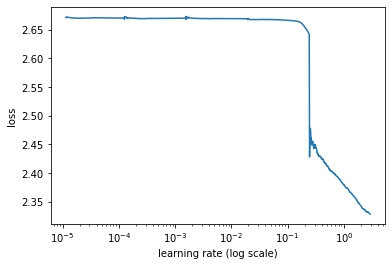

In [ ]:
# Plot the loss, ignore 20 batches in the beginning and 5 in the end
lr_finder.plot_loss(n_skip_beginning=20, n_skip_end=5)

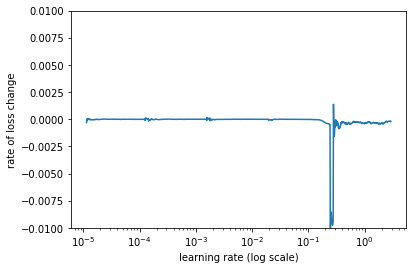

In [ ]:
# Plot rate of change of the loss
# Ignore 20 batches in the beginning and 5 in the end
# Smooth the curve using simple moving average of 20 batches
# Limit the range for y axis to (-0.02, 0.01)
lr_finder.plot_loss_change(sma=20, n_skip_beginning=20, n_skip_end=5, y_lim=(-0.01, 0.01))

In [ ]:
!git clone https://github.com/bckenstler/CLR.git

fatal: destination path 'CLR' already exists and is not an empty directory.


In [ ]:
from CLR.clr_callback import CyclicLR
# Set CLR options
step_size = int(3 * (50000/128))
base_lr = 0.1
max_lr = 1
mode='triangular'

# Define the callback
clr = CyclicLR(base_lr=base_lr, max_lr=max_lr, step_size=step_size, mode=mode)

resnet_20_kafs.fit(x=train, epochs = 100, batch_size=128, validation_data=test)

Epoch 1/100
391/391 [==============================] - 90s 230ms/step - loss: 2.6670 - accuracy: 0.1002 - val_loss: 2.6656 - val_accuracy: 0.0998
Epoch 2/100
391/391 [==============================] - 90s 230ms/step - loss: 2.6646 - accuracy: 0.1008 - val_loss: 2.6630 - val_accuracy: 0.1051
Epoch 3/100
391/391 [==============================] - 90s 231ms/step - loss: 2.6622 - accuracy: 0.1000 - val_loss: 2.6606 - val_accuracy: 0.1054
Epoch 4/100
391/391 [==============================] - 90s 231ms/step - loss: 2.6597 - accuracy: 0.1014 - val_loss: 2.6583 - val_accuracy: 0.1006
Epoch 5/100
391/391 [==============================] - 90s 230ms/step - loss: 2.6572 - accuracy: 0.0994 - val_loss: 2.6559 - val_accuracy: 0.1026
Epoch 6/100
391/391 [==============================] - 90s 231ms/step - loss: 2.6548 - accuracy: 0.0965 - val_loss: 2.6533 - val_accuracy: 0.1048
Epoch 7/100
391/391 [==============================] - 90s 231ms/step - loss: 2.6519 - accuracy: 0.1012 - val_loss: 2.6504 -

In [ ]:
# Set CLR options
step_size = int(5 * (50000/128))
base_lr = 0.01
max_lr = 0.8
mode='triangular'

# Define the callback
clr = CyclicLR(base_lr=base_lr, max_lr=max_lr, step_size=step_size, mode=mode)

resnet_20_kafs.fit(x=train, epochs = 100, batch_size=128, validation_data=test)

Epoch 1/100
391/391 [==============================] - 91s 232ms/step - loss: 2.6687 - accuracy: 0.0978 - val_loss: 2.6672 - val_accuracy: 0.0983
Epoch 2/100
391/391 [==============================] - 90s 230ms/step - loss: 2.6662 - accuracy: 0.0979 - val_loss: 2.6650 - val_accuracy: 0.0945
Epoch 3/100
391/391 [==============================] - 90s 230ms/step - loss: 2.6637 - accuracy: 0.0969 - val_loss: 2.6623 - val_accuracy: 0.0978
Epoch 4/100
391/391 [==============================] - 90s 229ms/step - loss: 2.6610 - accuracy: 0.0994 - val_loss: 2.6595 - val_accuracy: 0.0970
Epoch 5/100
391/391 [==============================] - 90s 230ms/step - loss: 2.6583 - accuracy: 0.1050 - val_loss: 2.6564 - val_accuracy: 0.1096
Epoch 6/100
391/391 [==============================] - 90s 229ms/step - loss: 2.6552 - accuracy: 0.1067 - val_loss: 2.6533 - val_accuracy: 0.1122
Epoch 7/100
391/391 [==============================] - 90s 229ms/step - loss: 2.6514 - accuracy: 0.1166 - val_loss: 2.6473 -

KeyboardInterrupt: ignored

In [ ]:
 resnet_20_kafs.fit(x=train, epochs = 3, batch_size=128, validation_data=test)

Epoch 1/3
391/391 [==============================] - 297s 759ms/step - loss: 3.6228 - accuracy: 0.1646 - val_loss: 3.0133 - val_accuracy: 0.2823
Epoch 2/3
391/391 [==============================] - 296s 757ms/step - loss: 2.6658 - accuracy: 0.2372 - val_loss: 2.3426 - val_accuracy: 0.3157
Epoch 3/3
391/391 [==============================] - 296s 757ms/step - loss: 2.2054 - accuracy: 0.2631 - val_loss: 1.9982 - val_accuracy: 0.3710


In [ ]:
!git clone https://github.com/christianversloot/keras_lr_finder/

Cloning into 'keras_lr_finder'...
remote: Enumerating objects: 1, done.
remote: Counting objects: 100% (1/1), done.
remote: Total 64 (delta 0), reused 1 (delta 0), pack-reused 63
Unpacking objects: 100% (64/64), done.


In [ ]:
!python keras_lr_finder/setup.py

usage: setup.py [global_opts] cmd1 [cmd1_opts] [cmd2 [cmd2_opts] ...]
   or: setup.py --help [cmd1 cmd2 ...]
   or: setup.py --help-commands
   or: setup.py cmd --help

error: no commands supplied


In [ ]:
import tensorflow_addons as tfa

Epoch 1/3
391/391 [==============================] - 296s 757ms/step - loss: 2.6716 - accuracy: 0.1000
Epoch 2/3
391/391 [==============================] - 296s 756ms/step - loss: 2.6829 - accuracy: 0.0979
Epoch 3/3
391/391 [==============================] - 296s 757ms/step - loss: 2.9329 - accuracy: 0.1000


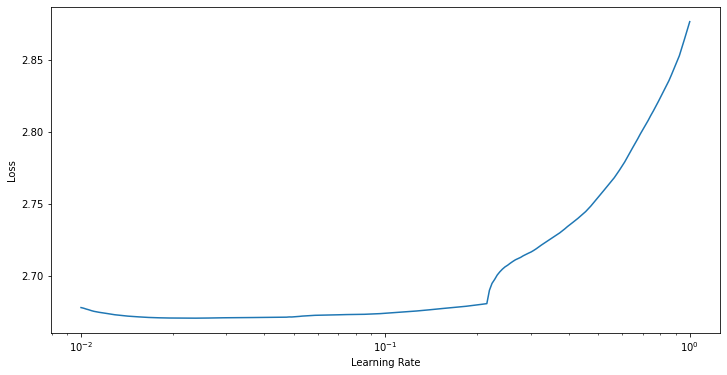

In [ ]:
# Learning rate bounds finder
from LRFinder. keras_callback import LRFinder
lr_finder = LRFinder(min_lr=1e-2, max_lr=1) 

resnet_20_kafs.fit(x=train, epochs = 3, batch_size=128, callbacks=[lr_finder])

In [ ]:
!git clone https://github.com/bckenstler/CLR.git
from CLR.clr_callback import CyclicLR

fatal: destination path 'CLR' already exists and is not an empty directory.


## Very strange, it seems like there is no valid lr in the range 1e-4;1
* Whatever, try with the same bounds as relu before

In [ ]:
from CLR.clr_callback import CyclicLR
# Set CLR options
step_size = int(3 * (50000/128))
base_lr = 1e-4
max_lr = 1e-3
mode='triangular'

# Define the callback
clr = CyclicLR(base_lr=base_lr, max_lr=max_lr, step_size=step_size, mode=mode)

In [ ]:
history = resnet_20_kafs.fit(x = train, epochs=3, validation_data=test, callbacks=[clr])

Epoch 1/3
391/391 [==============================] - 90s 231ms/step - loss: 2.6639 - accuracy: 0.0998 - val_loss: 2.6565 - val_accuracy: 0.0952
Epoch 2/3
391/391 [==============================] - 90s 229ms/step - loss: 2.5201 - accuracy: 0.1565 - val_loss: 2.4722 - val_accuracy: 0.2135
Epoch 3/3
391/391 [==============================] - 90s 229ms/step - loss: 2.2848 - accuracy: 0.2249 - val_loss: 2.2193 - val_accuracy: 0.2790


In [ ]:
history = resnet_20_kafs.fit(x = train, epochs=3, validation_data=test, callbacks=[clr])

Epoch 1/3
391/391 [==============================] - 90s 231ms/step - loss: 2.6687 - accuracy: 0.1000 - val_loss: 2.6687 - val_accuracy: 0.1000
Epoch 2/3
391/391 [==============================] - 90s 229ms/step - loss: 2.6685 - accuracy: 0.1000 - val_loss: 2.6683 - val_accuracy: 0.1001
Epoch 3/3
391/391 [==============================] - 90s 229ms/step - loss: 2.6681 - accuracy: 0.1000 - val_loss: 2.6677 - val_accuracy: 0.0995


In [ ]:
# Save model
resnet_20_kafs.save('/content/resnet20_kafs')
!zip -r resnet20_kafs.zip /content/resnet20_kafs
from google.colab import files
files.download('/content/resnet20_kafs.zip')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /content/resnet20_kafs/assets
  adding: content/resnet20_kafs/ (stored 0%)
  adding: content/resnet20_kafs/saved_model.pb (deflated 92%)
  adding: content/resnet20_kafs/assets/ (stored 0%)
  adding: content/resnet20_kafs/variables/ (stored 0%)
  adding: content/resnet20_kafs/variables/variables.data-00000-of-00001 (deflated 10%)
  adding: content/resnet20_kafs/variables/variables.index (deflated 78%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
history = resnet_20_kafs.fit(x = train, epochs=118, validation_data=test, callbacks=[clr])

Epoch 1/118
391/391 [==============================] - 292s 747ms/step - loss: 1.3225 - accuracy: 0.4526 - val_loss: 1.7164 - val_accuracy: 0.4275
Epoch 2/118
391/391 [==============================] - 292s 746ms/step - loss: 1.3935 - accuracy: 0.4269 - val_loss: 1.6033 - val_accuracy: 0.4640
Epoch 3/118
391/391 [==============================] - 292s 747ms/step - loss: 1.3736 - accuracy: 0.4394 - val_loss: 1.3088 - val_accuracy: 0.5724
Epoch 4/118
391/391 [==============================] - 292s 747ms/step - loss: 1.2973 - accuracy: 0.4651 - val_loss: 1.1241 - val_accuracy: 0.6471
Epoch 5/118
391/391 [==============================] - 292s 747ms/step - loss: 1.2160 - accuracy: 0.4955 - val_loss: 0.9510 - val_accuracy: 0.7238
Epoch 6/118
391/391 [==============================] - 292s 747ms/step - loss: 1.2102 - accuracy: 0.4922 - val_loss: 1.0914 - val_accuracy: 0.6506
Epoch 7/118
391/391 [==============================] - 292s 747ms/step - loss: 1.2960 - accuracy: 0.4627 - val_loss: 1